In [1]:
from dbhelper import PgDB, get_crossings
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
crossings = get_crossings()
crossings

,location_id,lane_id,direction_id,location_name,lane_name,direction_name
id,,,,,,
15,136,0,0,Lynden,Car,Northbound
16,136,0,1,Lynden,Car,Southbound
17,136,4,0,Lynden,Truck,Northbound
18,136,4,1,Lynden,Truck,Southbound
8,135,2,0,Pacific Highway,Bus,Northbound
7,135,2,1,Pacific Highway,Bus,Southbound
6,135,0,0,Pacific Highway,Car,Northbound
5,135,0,1,Pacific Highway,Car,Southbound
10,135,3,0,Pacific Highway,Fast,Northbound


## Peace Arch - South - Cars

In [3]:
query = '''
        select
            crossing_id as id,
            date,
            waittime,
            volume,
            valid
        from crossingdata
        where crossing_id = 1
        '''
with PgDB() as db:
    df = pd.read_sql(query, con=db.conn)
    
df = df.set_index('id')

In [4]:
len(df)

937728

In [5]:
df[df.waittime.isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108376 entries, 1 to 1
Data columns (total 4 columns):
date        108376 non-null datetime64[ns]
waittime    0 non-null float64
volume      16658 non-null float64
valid       108376 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 4.1 MB


### 108k missing wait time out of 937k records - 11.5%

In [6]:
sum((df.waittime.isnull()) & (df.volume.isnull()))

91718

In [7]:
sum((df.waittime.isnull()) & (df.volume.isnull()) & (df.valid == 1))

26566

### 92k missing both waittime and volume
### 26k due to known invalid data

In [8]:
df_nullwt = df[df.waittime.isnull()]

In [9]:
query = '''
        select date::date, count(*) as nulls
        from crossingdata 
        where crossing_id = 1 and waittime is null 
        group by date::date
        order by nulls desc;
        '''
with PgDB() as db:
    df_nullbyday = pd.read_sql(query, con=db.conn)

### Distribution of zeros is bifurcated
* Spike at 288 - all data missing
* Spike near zero

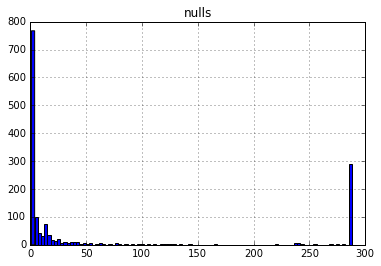

In [10]:
df_nullbyday.hist(bins=100);

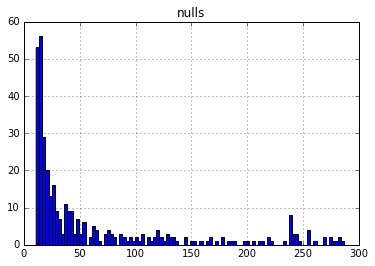

In [11]:
df_nullbyday[(df_nullbyday.nulls > 10) & (df_nullbyday.nulls < 288)].hist(bins=100);

### Not much data with null wait time and non-null volume
* Distribution is uninteresting
* Not much value in imputing just these values

In [12]:
query = '''
        select date::date, count(*) as nulls
        from crossingdata 
        where crossing_id = 1 and waittime is null and volume is not null
        group by date::date
        order by nulls desc;
        '''
with PgDB() as db:
    df_nullbyday2 = pd.read_sql(query, con=db.conn)

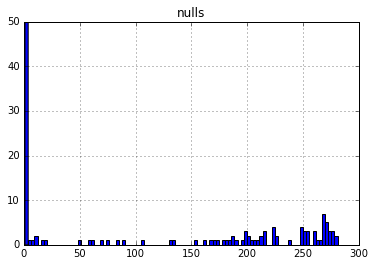

In [13]:
df_nullbyday2.hist(bins=100);

### Null wait times have several long periods of missing data
Perhaps a better avenue of investigation is whether we can ignore this data

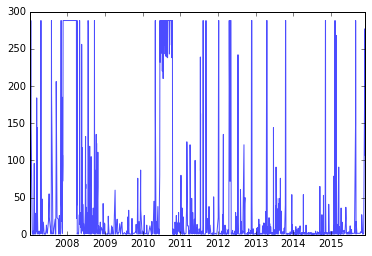

In [14]:
plt.plot(df_nullbyday.sort_values('date').date, df_nullbyday.sort_values('date').nulls, alpha=.7);

In [15]:
df_nullwt.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,16658,15.131588,12.661425,0,4,13,23,113
valid,108376,0.398834,0.489661,0,0,0,1,1


In [16]:
df_nonnullwt = df[~df.waittime.isnull()]

In [17]:
df_nonnullwt.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,829352,12.546665,19.900643,0,0,2,18,180
volume,813937,13.842875,12.323809,0,4,11,20,1118
valid,829352,1.000000,0.000000,1,1,1,1,1


In [18]:
from scipy.stats import ttest_ind

### The missing data definitely has a different distribution when comparing volume, but validity of test is questionable since so much of volume data is missing as well

Perhaps better to perform t-test against date features

In [19]:
ttest_ind(df_nullwt[~df_nullwt.volume.isnull()].volume, 
          df_nonnullwt[(df_nonnullwt.volume<200) & (~df_nonnullwt.volume.isnull())].volume)

Ttest_indResult(statistic=13.487771428338913, pvalue=1.8646450228432193e-41)

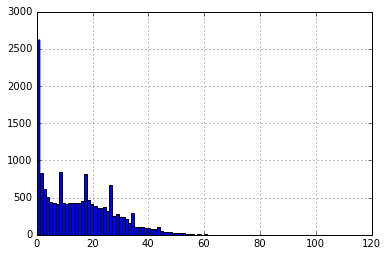

In [20]:
df_nullwt.volume.hist(bins=100);

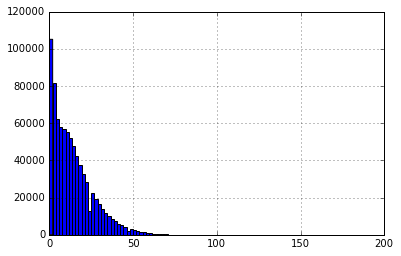

In [21]:
df_nonnullwt[df_nonnullwt.volume<200].volume.hist(bins=100);

In [22]:
with PgDB() as db:
    df_date = pd.read_sql('select * from datefeatures', con=db.conn)

In [23]:
df_nullwt = df_nullwt.merge(df_date, on='date')

In [24]:
df_nonnullwt = df_nonnullwt.merge(df_date, on='date')

In [25]:
df_nullwt.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volume,16657,15.132497,12.661262,0,4,13,23,113
valid,108270,0.398264,0.489543,0,0,0,1,1
year,108270,2009.393775,1.970550,2007,2008,2010,2010,2015
month,108270,6.461642,3.584328,1,3,7,9,12
dayofmonth,108270,15.798845,8.736543,1,8,16,23,31
week,108270,26.092713,15.546496,1,11,28,38,53
dayofweek,108270,3.012829,2.037914,0,1,3,5,6


In [26]:
df_nonnullwt.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,829171,12.547841,19.902384,0,0,2,18,180
volume,813758,13.842945,12.324398,0,4,11,20,1118
valid,829171,1.000000,0.000000,1,1,1,1,1
year,829171,2011.164586,2.561503,2007,2009,2011,2013,2015
month,829171,6.470802,3.401076,1,4,6,9,12
dayofmonth,829171,15.711597,8.803737,1,8,16,23,31
week,829171,26.384231,14.859513,1,14,26,39,53
dayofweek,829171,2.998321,1.994994,0,1,3,5,6


### Weight features show similar t-test results

In [27]:
ttest_ind(df_nullwt[~df_nullwt.volume.isnull()].month, 
          df_nonnullwt[(df_nonnullwt.volume<200) & (~df_nonnullwt.volume.isnull())].month)

Ttest_indResult(statistic=32.774128072571045, pvalue=1.9485885593518323e-235)

In [28]:
ttest_ind(df_nullwt[~df_nullwt.volume.isnull()].dayofmonth, 
          df_nonnullwt[(df_nonnullwt.volume<200) & (~df_nonnullwt.volume.isnull())].dayofmonth)

Ttest_indResult(statistic=-2.6111630835361819, pvalue=0.0090236473238212971)

In [29]:
ttest_ind(df_nullwt[~df_nullwt.volume.isnull()].week, 
          df_nonnullwt[(df_nonnullwt.volume<200) & (~df_nonnullwt.volume.isnull())].week)

Ttest_indResult(statistic=28.049400563429405, pvalue=4.8962614461084699e-173)

In [30]:
ttest_ind(df_nullwt[~df_nullwt.volume.isnull()].dayofweek, 
          df_nonnullwt[(df_nonnullwt.volume<200) & (~df_nonnullwt.volume.isnull())].dayofweek)

Ttest_indResult(statistic=6.052978557874229, pvalue=1.4225237834543454e-09)

### Revisit missing data by date

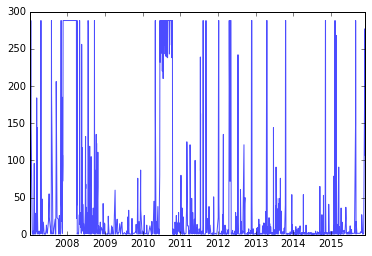

In [31]:
plt.plot(df_nullbyday.sort_values('date').date, df_nullbyday.sort_values('date').nulls, alpha=.7);

### 38k missing records at 2008 boundary

In [32]:
df[(df.date > datetime.date(2007, 11, 19)) & (df.date < datetime.date(2008, 4, 2))].info()

NameError: name 'datetime' is not defined

### 33k missing records in 2010

In [ ]:
df[(df.date > datetime.date(2010, 6, 17)) & (df.date < datetime.date(2010, 10, 13))].info()

### Total of 71k of 108k missing records due to 2 major gaps

In [ ]:
ttest_ind(df_nullwt[(df_nullwt > datetime.date(2011, 1, 1)) & (~df_nullwt.volume.isnull())].volume, 
          df_nonnullwt[(df_nonnullwt > datetime.date(2011, 1, 1)) & (~df_nonnullwt.volume.isnull())].volume)